In [41]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

from _helpers import three_2_two_digits_country

In [45]:
# OSM raw data files
substations_OSMraw_path = ("test4/pypsa-earth/resources/osm/raw/all_raw_substations.geojson")
lines_OSMraw_path = ("test4/pypsa-earth/resources/osm/raw/all_raw_lines.geojson")

# OSM cleaned data files
substations_OSMclean_path = ("test4/pypsa-earth/resources/osm/clean/all_clean_substations.geojson")
lines_OSMclean_path = ("test4/pypsa-earth/resources/osm/clean/all_clean_lines.geojson")

# shape files
countries_shape_path = "test4/pypsa-earth/resources/shapes/country_shapes.geojson"

# solved networks output
base_path = "test4/pypsa-earth/saved_networks/4_nodes_validation_network/results/elec_s_4_ec_lcopt_Co2L-1H.nc" 

In [46]:
# import packages

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, pleas

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


(<matplotlib.collections.PatchCollection at 0x1df95b43460>,
 <matplotlib.collections.LineCollection at 0x1df93854910>)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


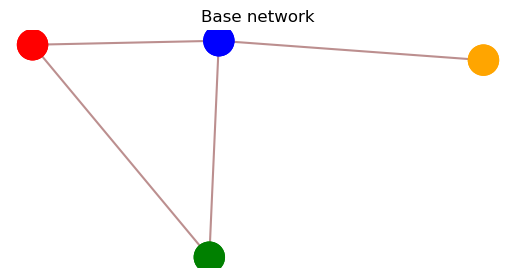

In [47]:
# validation base network plot

base_n = pypsa.Network(base_path)
n_buses = base_n.buses
bus_colors = {
    'BO0 0': "red",
    'BO0 1': "blue",
    'BO0 2': "green",
    'BO0 3': "orange", 
    'BO0 0 battery': "red",
    'BO0 1 battery': "blue",
    'BO0 2 battery': "green",
    'BO0 3 battery': "orange"
    
}


pypsa.plot.plot(bus_colors=bus_colors, title="Base network", n=base_n)

In [48]:
base_n.buses

v_nom country          x          y control   generator  \
Bus                                                                      
BO0 0          220.0      BO -67.382533 -17.429067   Slack  BO0 0 OCGT   
BO0 1          220.0      BO -65.704740 -17.393010      PQ               
BO0 2          220.0      BO -65.790486 -19.342000      PQ               
BO0 3          220.0      BO -63.321900 -17.567400      PQ               
BO0 0 battery    1.0      BO -67.382533 -17.429067   Slack               
BO0 1 battery    1.0      BO -65.704740 -17.393010   Slack               
BO0 2 battery    1.0      BO -65.790486 -19.342000   Slack               
BO0 3 battery    1.0      BO -63.321900 -17.567400   Slack               

               carrier type unit  v_mag_pu_set  v_mag_pu_min  v_mag_pu_max  \
Bus                                                                          
BO0 0               AC                     1.0           0.0           inf   
BO0 1               AC                     1.0           0.0           inf   
BO0 2               AC                     1.0           0.0           inf   
BO0 3               AC                     1.0           0.0           inf   
BO0 0 battery  battery                     1.0           0.0           inf   
BO0 1 battery  battery                     1.0           0.0           inf   
BO0 2 battery  battery                     1.0           0.0           inf   
BO0 3 battery  battery                     1.0           0.0           inf   

              sub_network  
Bus                        
BO0 0                      
BO0 1                      
BO0 2                      
BO0 3                      
BO0 0 battery              
BO0 1 battery              
BO0 2 battery              
BO0 3 battery

In [49]:
# load substation geodataframe
df_substations_osm_clean = gpd.read_file(
    substations_OSMclean_path
)  # .to_crs(epsg=3857)
# df_substations_osm_clean = df_substations_osm_clean[
#     df_substations_osm_clean.country == "NG"
# ]
df_substations_osm_clean["geometry"] = df_substations_osm_clean["geometry"].apply(
    make_valid
)
# load lines geodataframe
df_lines_osm_clean = gpd.read_file(lines_OSMclean_path)  # .to_crs(epsg=3857)
# df_lines_osm_clean = df_lines_osm_clean[df_lines_osm_clean.country == "NG"]
df_lines_osm_clean["geometry"] = df_lines_osm_clean["geometry"].apply(make_valid)

In [50]:
voltage_substations = df_substations_osm_clean.voltage.unique()
voltage_substations.sort()
voltage_substations

array([ 69000, 115000, 132000, 230000], dtype=int64)

In [51]:
unique_voltages = df_lines_osm_clean.voltage.unique()
unique_voltages.sort()
unique_voltages

array([ 69000, 115000, 132000, 230000], dtype=int64)

In [52]:
color_voltages = ["orange", "blue", "red", "green"]

voltage_to_color = {v: c for (v, c) in zip(unique_voltages, color_voltages)}
voltage_to_color

{69000: 'orange', 115000: 'blue', 132000: 'red', 230000: 'green'}

In [53]:
# get all country shapes
country_shapes = gpd.read_file(countries_shape_path)

# get bolivia shape
df_geometry = country_shapes.set_index("name").geometry

# get bounds
# print("Original bounds:")
# print(df_geometry.boundary.bounds)

# add tolerance to bounds
tol = 0.2

bounds_mod = df_geometry.boundary.bounds
bounds_mod["minx"] -= tol  # reduce minx
bounds_mod["miny"] -= tol  # reduce miny
bounds_mod["maxx"] += tol  # increase maxx
bounds_mod["maxy"] += tol  # increase maxy

print("Modified bounds:")
print(bounds_mod)

# reorder bounds to comply with extend function (x0, x1, y0, y1)
extent_list = list(bounds_mod[["minx", "maxx", "miny", "maxy"]].loc["BO"])

Modified bounds:
           minx       miny       maxx      maxy
name                                           
BO   -69.845246 -23.106568 -57.254434 -9.470923


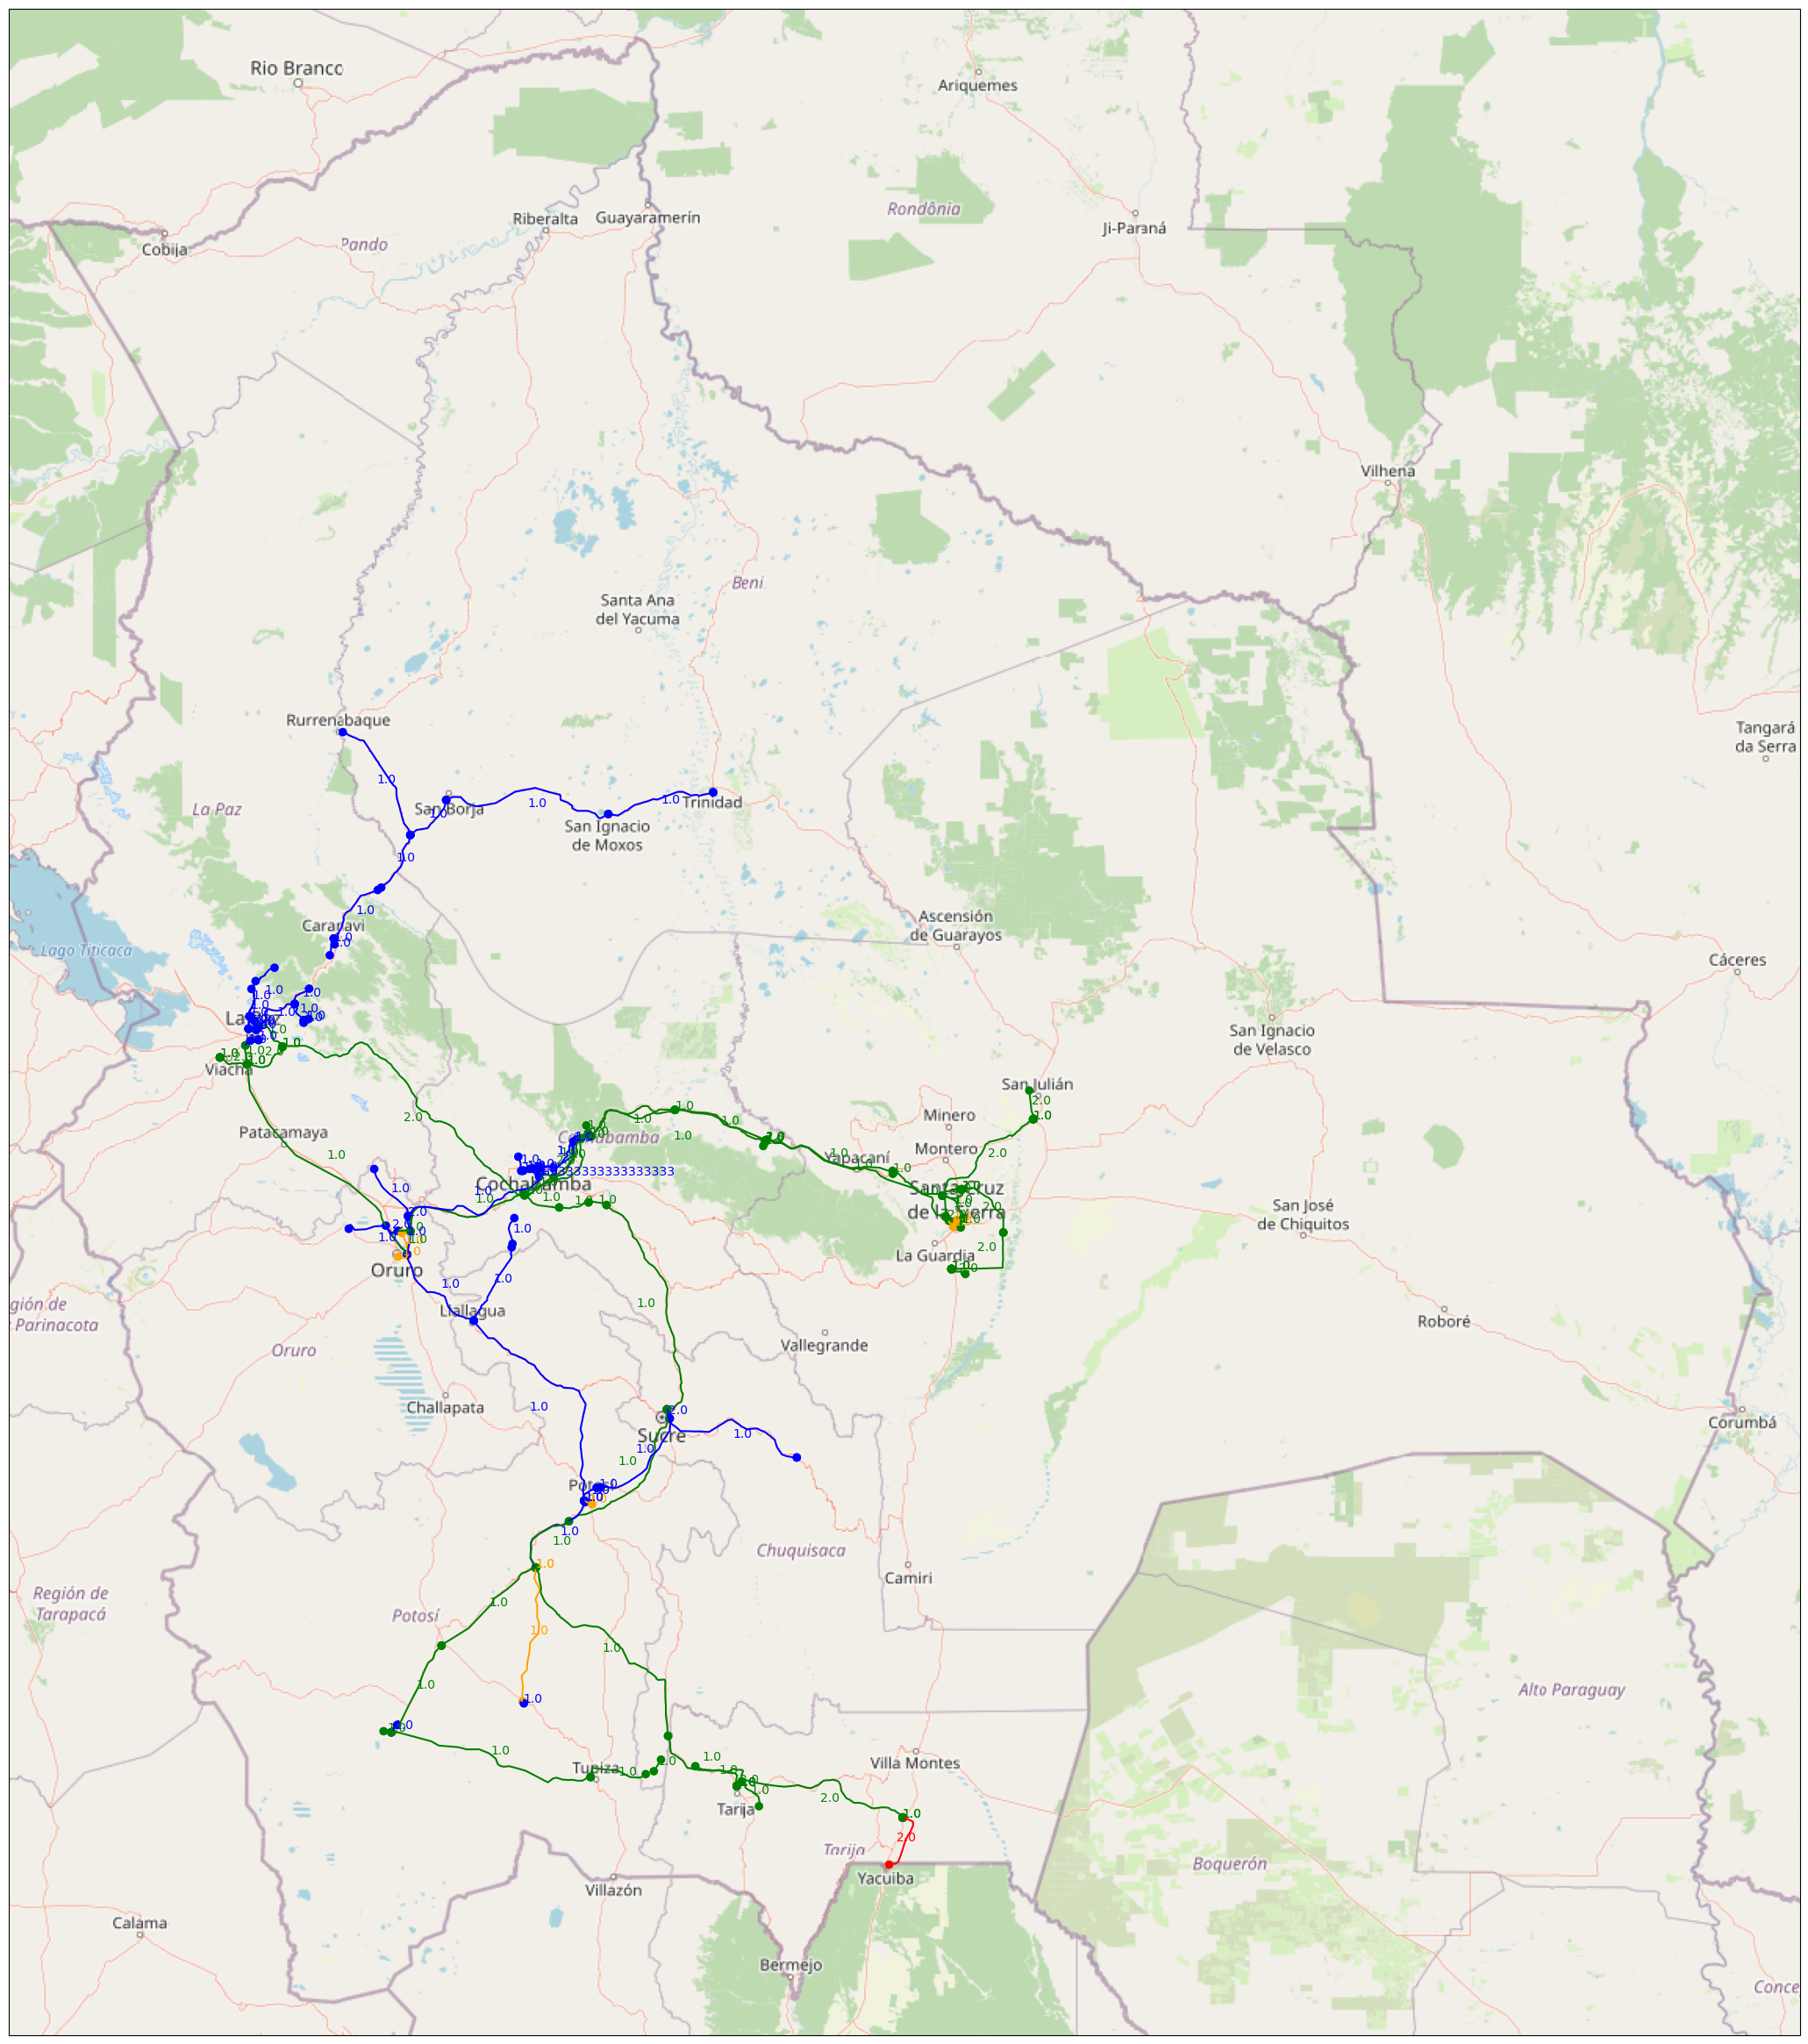

In [54]:
%matplotlib inline

# get the structure of the background data to plot
imagery = OSM()

max_width = 30  # max width of the figure
max_height = 30  # max heifht of the figure

# calculate figure size with appropriate multiplier to adhere to the desired width/height
multiplier = min(
    max_width / (extent_list[1] - extent_list[0]),
    max_height / (extent_list[3] - extent_list[2]),
)
figsize = (
    (extent_list[1] - extent_list[0]) * multiplier,
    (extent_list[3] - extent_list[2]) * multiplier,
)


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)  # specify projection
ax.set_extent(extent_list, ccrs.PlateCarree())  # specify the location of the image
ax.add_image(imagery, 7)  # add the background image

# create an auxiliary dataframe for the substations with the desired crs and color properties
df_substations_osm_clean_plot = df_substations_osm_clean.to_crs(imagery.crs)
# specify the color of the nodes
df_substations_osm_clean_plot["color"] = df_substations_osm_clean_plot.voltage.apply(
    lambda x: voltage_to_color[x]
)


# create an auxiliary dataframe for the lines with the desired crs and properties
df_lines_osm_clean_plot = df_lines_osm_clean.to_crs(imagery.crs)
df_lines_osm_clean_plot[
    "centroids"
] = df_lines_osm_clean_plot.geometry.boundary.centroid  # get the centroids of the line
df_lines_osm_clean_plot["color"] = df_lines_osm_clean_plot.voltage.apply(
    lambda x: voltage_to_color[x]
)  # specify the color of the line

# draw the substations
df_substations_osm_clean_plot.plot(color=df_substations_osm_clean_plot.color, ax=ax)

# draw the lines
df_lines_osm_clean_plot.plot(color=df_lines_osm_clean_plot.color, ax=ax)

# add annotations to show the number of circuits by line
for (id, row) in df_lines_osm_clean_plot.iterrows():
    ax.text(row.centroids.x, row.centroids.y, row.circuits, color=row.color)

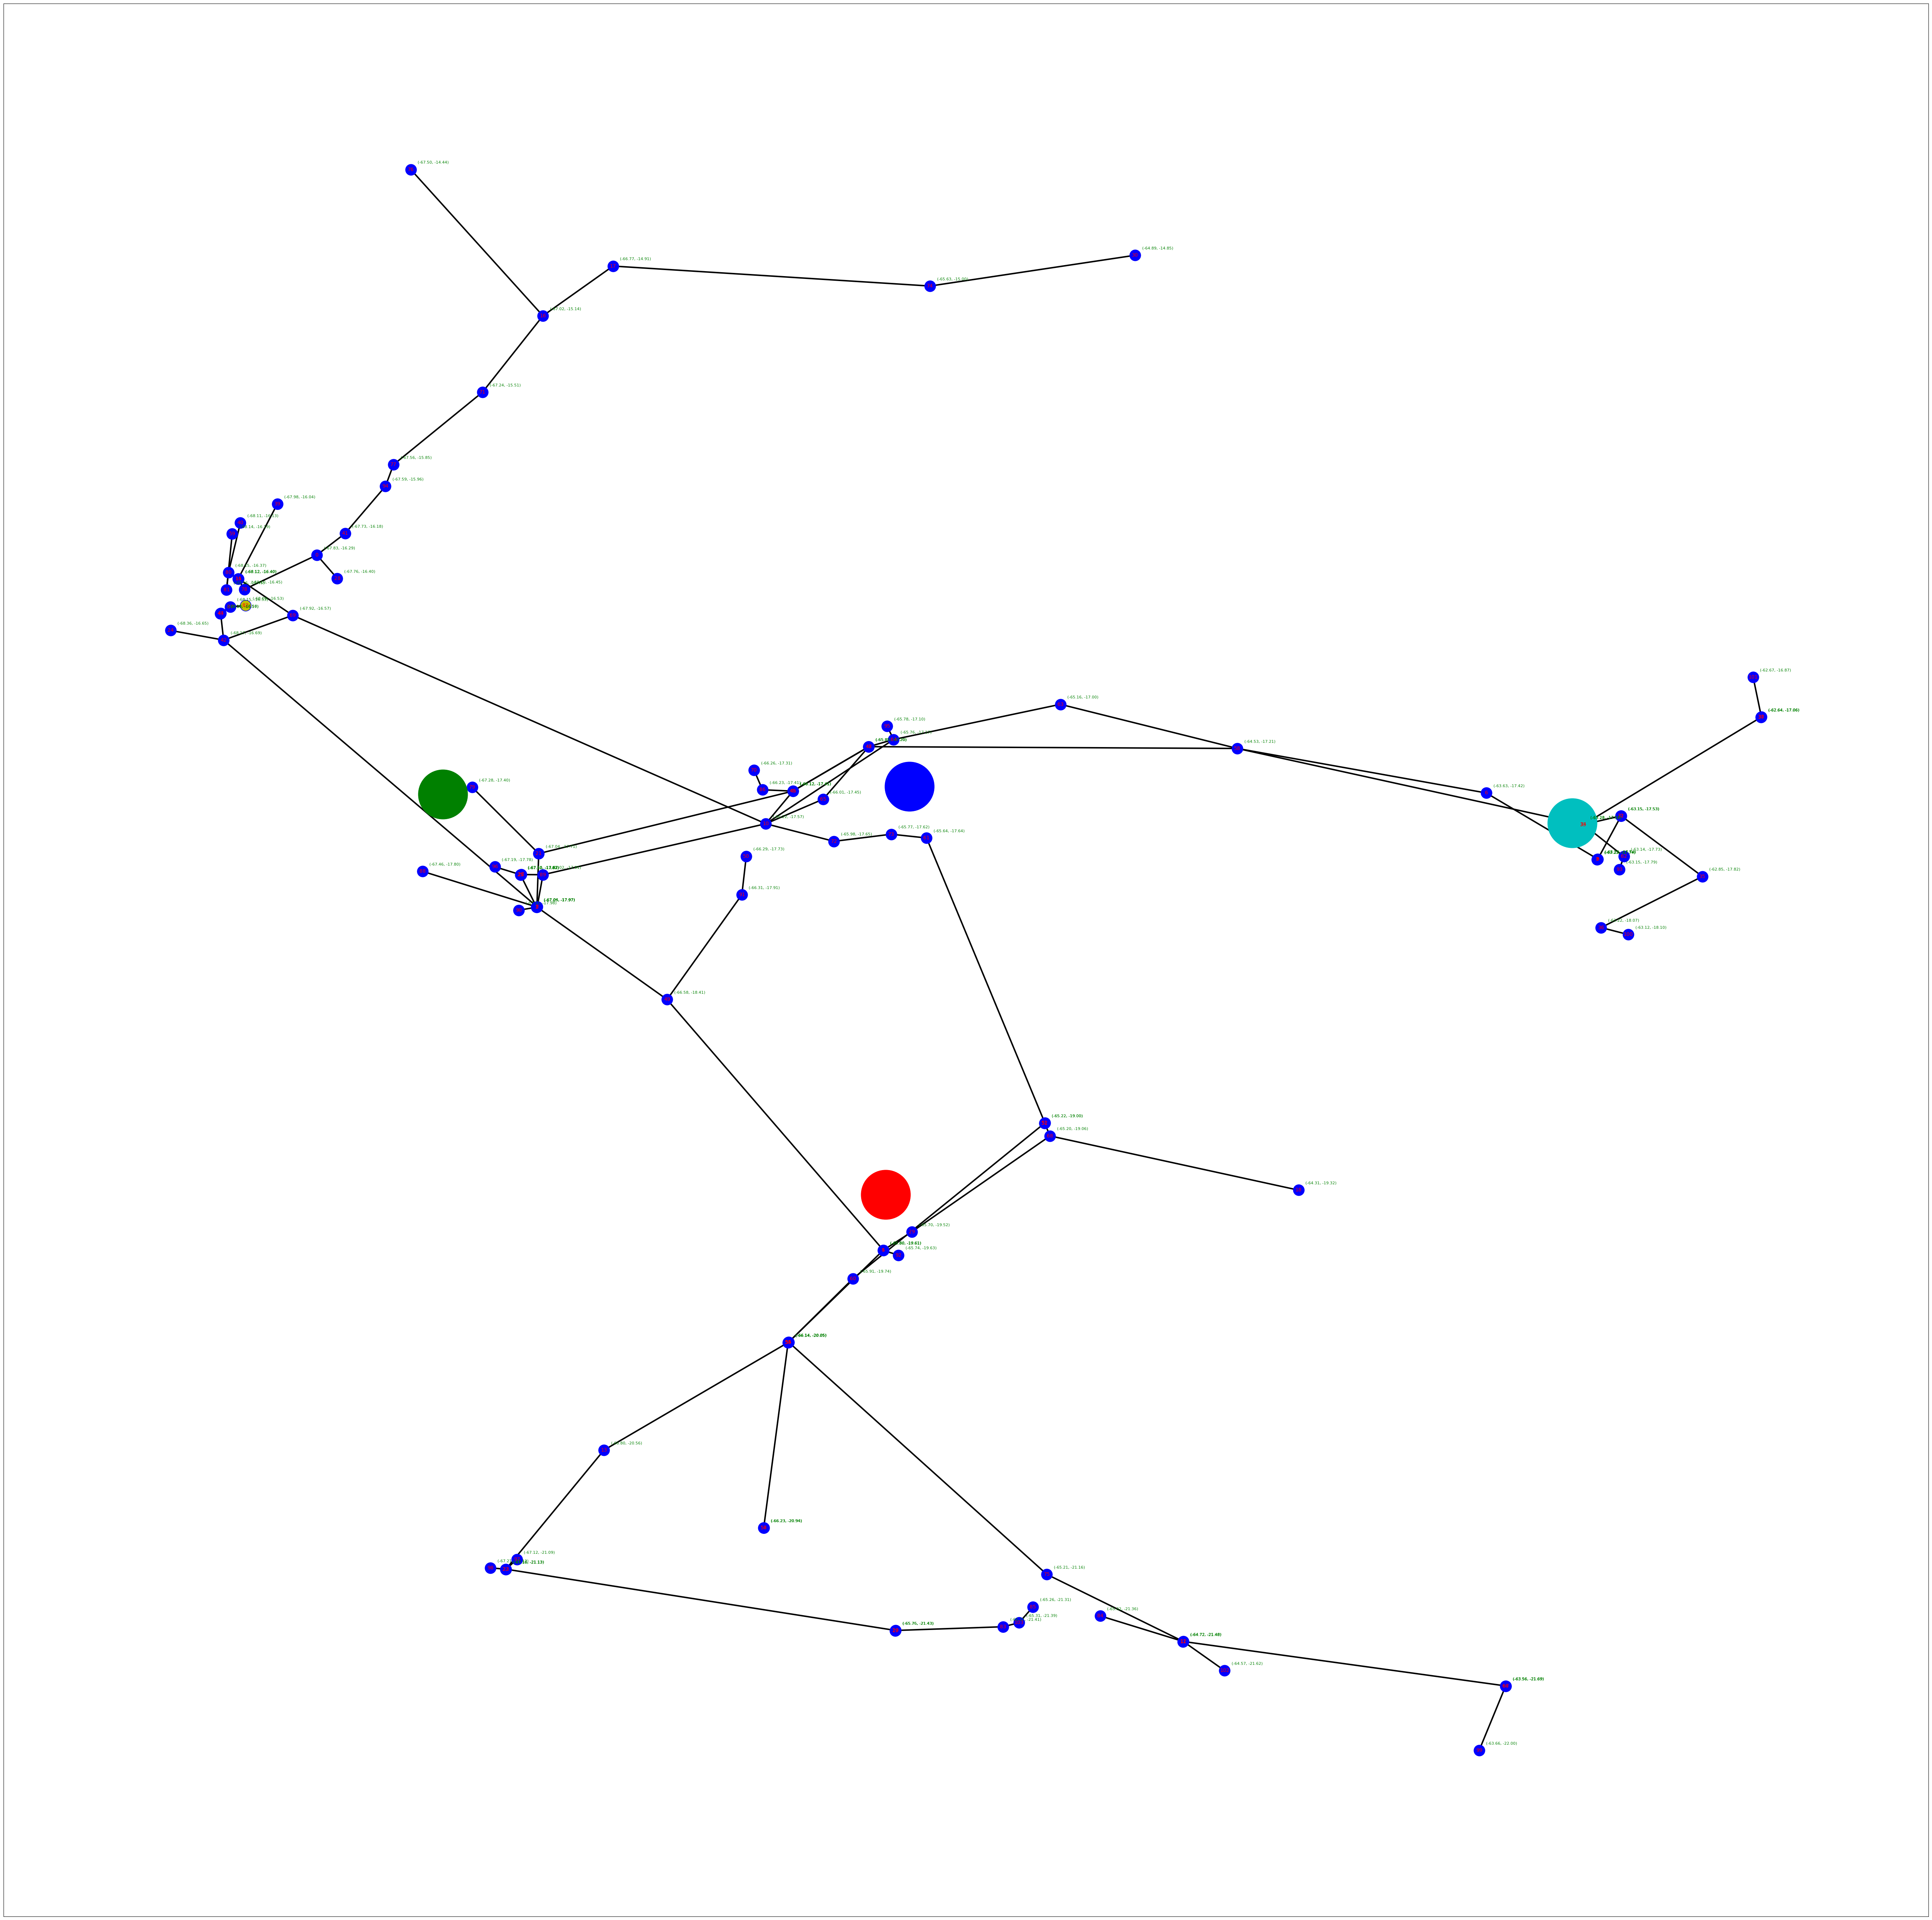

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import pandas as pd

G = nx.Graph()

# Read the CSV files
df_buses = pd.read_csv("test4/pypsa-earth/resources/base_network/all_buses_build_network.csv")
df_lines = pd.read_csv("test4/pypsa-earth/resources/base_network/all_lines_build_network.csv")
df_transformers = pd.read_csv("test4/pypsa-earth/resources/base_network/all_transformers_build_network.csv")

# Combine dataframes
df1 = df_lines[["bus0", "bus1"]]
df3 = df_transformers[["bus0", "bus1"]]
df4 = pd.concat([df1, df3])

# Create graph from edge list
G = nx.from_pandas_edgelist(df4, 'bus0', 'bus1')

# Create a position dictionary based on coordinates
pos = {node: (row['lon'], row['lat']) for node, row in df_buses.iterrows()}
pos = {row['bus_id']: (row['lon'], row['lat']) for _, row in df_buses.iterrows()}

plt.figure(figsize=(70, 70))

# Draw the main graph
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='blue')

# Draw isolated clusters in a different color
isolated_nodes = list(nx.isolates(G))
if isolated_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=isolated_nodes, node_size=500, node_color='red')

# Draw edges
nx.draw_networkx_edges(G, pos, width=3)

# Add labels with indices inside the nodes
for node, (x, y) in pos.items():
    plt.text(x, y, s=node, horizontalalignment='center', verticalalignment='center', fontsize=10, color='red')
    
for node_id in G.nodes():  # Ensure you're iterating over the graph's nodes
    x, y = pos[node_id]
    degree = G.degree[node_id]  # This should not raise KeyError if node_id is in G

# Add labels with coordinates next to the nodes
for node, (x, y) in pos.items():
    coord_text = f'({x:.2f}, {y:.2f})'
    #degree = G.degree[node]
    offset_x = 0.02 + 0.005 * degree
    offset_y = 0.02 + 0.005 * degree
    plt.text(x + offset_x, y + offset_y, s=coord_text, horizontalalignment='left', verticalalignment='bottom', fontsize=8, color='green')
    
# Add a position point for the isolated node on the map
plt.plot(-68.091500, -16.527800, "yo", markersize=20)

# Add the other points 
plt.plot(-65.790486, -19.342000, "ro", markersize=100)
plt.plot(-65.704740, -17.393010, "bo", markersize=100)
plt.plot(-67.382533, -17.429067, "go", markersize=100)
plt.plot(-63.321900, -17.567400, "co", markersize=100)

plt.show()


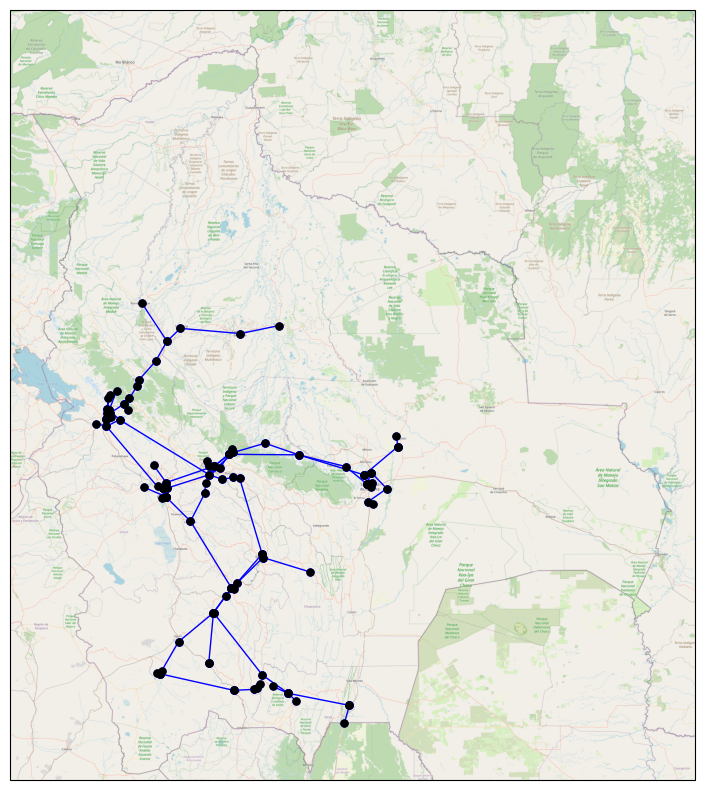

In [56]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import networkx as nx

# Assuming df_buses, df_lines, df_transformers are your DataFrames loaded from CSV files

# Normalize the node identifiers in dataframes to be strings
df_buses['bus_id'] = df_buses['bus_id'].astype(str)
df_lines['bus0'] = df_lines['bus0'].astype(str)
df_lines['bus1'] = df_lines['bus1'].astype(str)
df_transformers['bus0'] = df_transformers['bus0'].astype(str)
df_transformers['bus1'] = df_transformers['bus1'].astype(str)

# Create a graph from the dataframes
G = nx.Graph()

# Combine dataframes for lines and transformers to create edges
df_edges = pd.concat([df_lines[["bus0", "bus1"]], df_transformers[["bus0", "bus1"]]])

# Add edges to the graph
G = nx.from_pandas_edgelist(df_edges, 'bus0', 'bus1')

# Convert bus_id to the appropriate type (e.g., string)
df_buses['bus_id'] = df_buses['bus_id'].astype(str)  # Use .astype(int) if your graph uses integers

# Create a position dictionary based on coordinates
# Replace 'bus_id', 'lon', 'lat' with the actual column names from df_buses
# Rebuild the pos dictionary making sure that node identifiers match those in G
pos = {str(row['bus_id']): (row['lon'], row['lat']) for _, row in df_buses.iterrows() if str(row['bus_id']) in G.nodes}


# Validate nodes in 'pos' against the graph 'G'
missing_nodes = [node for node in pos if node not in G]
for node in missing_nodes:
    del pos[node]  # Remove missing nodes from 'pos'

# Set up the map tiles from OSM
imagery = cimgt.OSM()

# Define your figure and axis with a cartopy projection
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': imagery.crs})


# Set the extent of the map (adjust the extent if necessary)
extent = [-70, -57, -23, -9]  # Slightly expanded extent to the left
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add the OSM image with a specific zoom level
ax.add_image(imagery, 8)

# Draw the graph
for edge in G.edges():
    start, end = edge
    x0, y0 = pos[start]
    x1, y1 = pos[end]
    ax.plot([x0, x1], [y0, y1], color='blue', linewidth=1, marker='o', markersize=5, transform=ccrs.Geodetic())

# Draw nodes
for node_id in G.nodes():  # Ensure you're iterating over the graph's nodes
    x, y = pos[node_id]
    ax.plot(x, y, marker='o', color='black', markersize=5, transform=ccrs.Geodetic())
    degree = G.degree[node_id]
    # Add labels with coordinates next to the nodes
    coord_text = ""
    offset_x = 0.02 + 0.005 * degree  # Adjust these values as needed
    offset_y = 0.02 + 0.005 * degree  # Adjust these values as needed
    ax.text(x + offset_x, y + offset_y, s=coord_text, horizontalalignment='left', verticalalignment='bottom', fontsize=8, color='green', transform=ccrs.Geodetic())


plt.show()


In [57]:
# substations
substations_OSMraw_path = os.getcwd() + "/pypsa-earth/resources/osm/raw/all_raw_substations.geojson"
df_substations_raw_osm_southamerica = gpd.read_file(substations_OSMraw_path).to_crs(epsg=3857)
df_substations_raw_osm_bolivia = df_substations_raw_osm_southamerica[
    df_substations_raw_osm_southamerica.Country == "BO"
]

# lines
lines_OSMraw_path = os.getcwd() + "/pypsa-earth/resources/osm/raw/all_raw_lines.geojson"
df_lines_raw_osm_southamerica = gpd.read_file(lines_OSMraw_path).to_crs(epsg=3857)
df_lines_raw_osm_bolivia = df_lines_raw_osm_southamerica[
    df_lines_raw_osm_southamerica.Country == "BO"
]

In [58]:
# substations
substations_OSMclean_path = os.getcwd() + "/pypsa-earth/resources/osm/clean/all_clean_substations.geojson"
df_substations_clean_osm_southamerica = gpd.read_file(substations_OSMclean_path)
df_substations_clean_osm_southamerica["geometry"] = (
    df_substations_clean_osm_southamerica["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_substations_clean_osm_bolivia = df_substations_clean_osm_southamerica[
    df_substations_clean_osm_southamerica.country == "BO"
]

# lines
lines_OSMclean_path = os.getcwd() + "/pypsa-earth/resources/osm/clean/all_clean_lines.geojson"
df_lines_clean_osm_southamerica = gpd.read_file(lines_OSMclean_path)
df_lines_clean_osm_southamerica["geometry"] = (
    df_lines_clean_osm_southamerica["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_lines_clean_osm_bolivia = df_lines_clean_osm_southamerica[
    df_lines_clean_osm_southamerica.country == "BO"
]

In [59]:
countries_shape_path = os.getcwd() + "/pypsa-earth/resources/shapes/country_shapes.geojson"
southamerica_shape = gpd.read_file(countries_shape_path)
bolivia_shape = southamerica_shape.set_index("name").loc["BO"].geometry

In [60]:
df_lines_raw_osm_southamerica["length_by_geometry"] = df_lines_raw_osm_southamerica.to_crs(
    epsg=3857
).geometry.length

In [61]:
# SOUTHAMERCIA
df_lines_raw_osm_southamerica["cables_fix"] = df_lines_raw_osm_southamerica["tags.cables"].copy()
df_lines_raw_osm_southamerica.loc[
    df_lines_raw_osm_southamerica["tags.cables"].isnull()
    | df_lines_raw_osm_southamerica["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_southamerica["length_km"] = (
    df_lines_raw_osm_southamerica.to_crs(epsg=3857).geometry.length
    * df_lines_raw_osm_southamerica["cables_fix"].astype(float)
    / 3
)
length_raw_osm = (
    df_lines_raw_osm_southamerica.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_raw_osm = pd.DataFrame(length_raw_osm)
df_raw_osm.index = voltage

lengths_southamerica = pd.DataFrame()
df = df_raw_osm
lengths_southamerica["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_southamerica["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_southamerica["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_southamerica["scope"] = "South America"
lengths_southamerica["reference"] = "Open Street Map (raw)"

### NIGERIA
df_lines_raw_osm_bolivia["cables_fix"] = df_lines_raw_osm_bolivia["tags.cables"].copy()
df_lines_raw_osm_bolivia.loc[
    df_lines_raw_osm_bolivia["tags.cables"].isnull()
    | df_lines_raw_osm_bolivia["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_bolivia["length_km"] = (
    df_lines_raw_osm_bolivia.to_crs(epsg=3857).geometry.length
    * df_lines_raw_osm_bolivia["cables_fix"].astype(float)
    / 3
)
length_raw_osm = (
    df_lines_raw_osm_bolivia.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_lines_raw_osm_nigeria = pd.DataFrame(length_raw_osm)
df_lines_raw_osm_nigeria.index = voltage

lengths_bo = pd.DataFrame()
df = df_lines_raw_osm_nigeria
lengths_bo["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_bo["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_bo["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_bo["scope"] = "Bolivia"
lengths_bo["reference"] = "Open Street Map (raw)"

### COMBINE OUTPUT
osm_raw_lengths = pd.concat([lengths_southamerica, lengths_bo])
osm_raw_lengths

110-220kV    220-380kV  380+kV          scope  \
length_km  2022.471057  4193.796057     0.0  South America   
length_km  2022.471057  4193.796057     0.0        Bolivia   

                       reference  
length_km  Open Street Map (raw)  
length_km  Open Street Map (raw)

In [62]:
### AFRICA
df = df_lines_clean_osm_southamerica
df["length"] = df.to_crs(epsg=3857).geometry.length * df.circuits / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
lengths_southamerica = pd.DataFrame()
df = df_clean_osm
lengths_southamerica["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_southamerica["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_southamerica["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_southamerica["scope"] = "South America"
lengths_southamerica["reference"] = "Open Street Map (clean)"

### NIGERIA
df = df_lines_clean_osm_bolivia
df["length"] = df.to_crs(epsg=3857).geometry.length * df.circuits / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
lengths_bo = pd.DataFrame()
df = df_clean_osm
lengths_bo["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_bo["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_bo["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_bo["scope"] = "Bolivia"
lengths_bo["reference"] = "Open Street Map (clean)"

### COMBINE OUTPUT
osm_clean_lengths = pd.concat([lengths_southamerica, lengths_bo])
osm_clean_lengths

110-220kV    220-380kV  380+kV          scope  \
length  1976.602201  4193.796057     0.0  South America   
length  1976.602201  4193.796057     0.0        Bolivia   

                      reference  
length  Open Street Map (clean)  
length  Open Street Map (clean)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


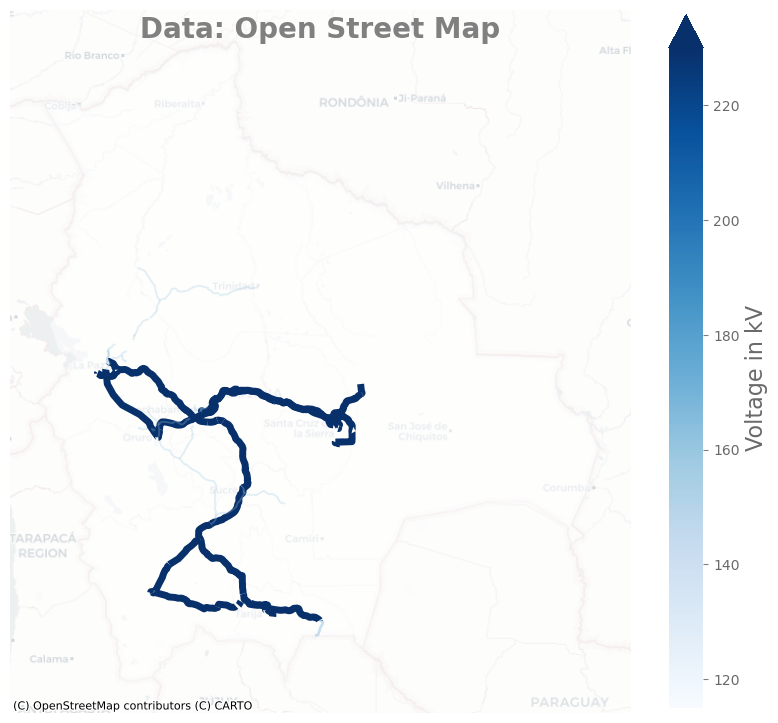

In [63]:
import contextily as cx  # Need to be installed `pip3 install contextily`
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

# adapt all sizes
size = 0.5
# Create the basemap that is called by ax
ax = southamerica_shape.to_crs(epsg="3857").plot(
    figsize=(20 * size, 20 * size), alpha=0.5, facecolor="white", edgecolor="whitesmoke"
)

# Create open street map background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.4)

# Create open street map background map
df = df_lines_clean_osm_southamerica[df_lines_clean_osm_southamerica.country == "BO"]
df = df_lines_clean_osm_southamerica[df_lines_clean_osm_southamerica.voltage >= 110000]

# Scale and format stuff
blues = cm.get_cmap("Blues")
dfact = 0.28  # impacts min-max differences of weight, transparency and color
widthscale = 10 * size
df["normalized_v"] = (1 - dfact) * (df["voltage"] - df["voltage"].min()) / (
    df["voltage"].max() - df["voltage"].min()
) + dfact
line = df
normalized_voltage = df.normalized_v

line.plot(
    ax=ax,
    alpha=normalized_voltage,
    linewidth=normalized_voltage * widthscale,
    color=blues(normalized_voltage + 0.1),
    legend=True,
)
ax.set_title(
    "Data: Open Street Map",
    fontsize=40 * size,
    y=1.0,
    pad=-40 * size,
    fontweight="bold",
    color="grey",
)
ax.set_axis_off()

# Colorbar
cmap = blues
norm = mpl.colors.Normalize(
    vmin=df["voltage"].min() / 1000, vmax=df["voltage"].max() / 1000
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    extend="max",
    shrink=0.9,
)
cbar.set_label("Voltage in kV", fontsize=16, color="dimgrey")
# ticks & edge modification of cbar
cbar.ax.yaxis.set_tick_params(color="grey")
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color="dimgrey")
cbar.outline.set_edgecolor(None)  # set colorbar edgecolor


c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


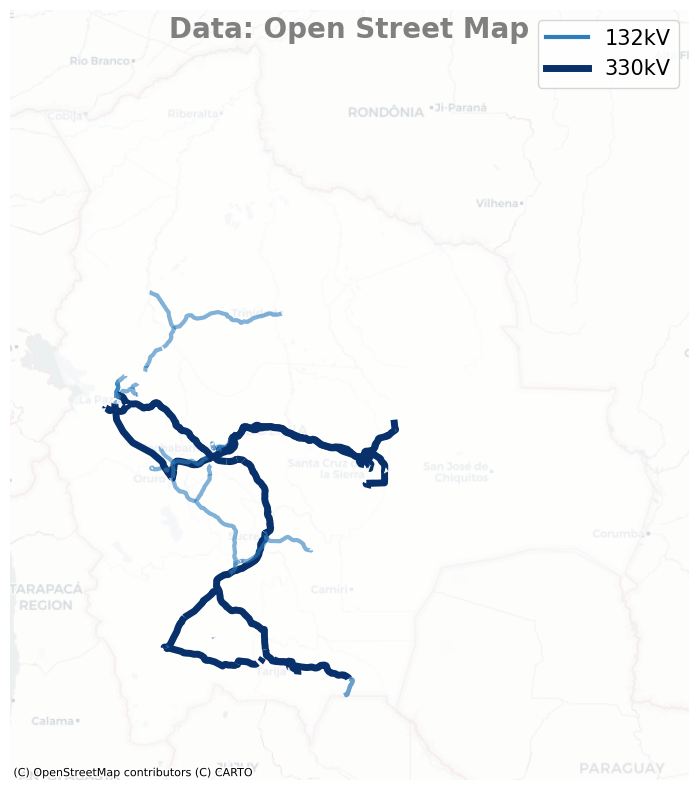

In [64]:
# adapt all sizes
size = 0.5
# Create the basemap that is called by ax
ax = (
    southamerica_shape[southamerica_shape.name == "BO"]
    .to_crs(epsg="3857")
    .plot(
        figsize=(20 * size, 20 * size),
        alpha=0.5,
        facecolor="white",
        edgecolor="whitesmoke",
    )
)

# Create open street map background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.4)

# Create open street map background map
df0 = df_lines_clean_osm_bolivia[df_lines_clean_osm_bolivia.country == "BO"]
df = df0[df0.voltage >= 110000]

# Scale and format stuff
blues = cm.get_cmap("Blues")
dfact = 0.6  # impacts min-max differences of weight, transparency and color
widthscale = 10 * size
df["normalized_v"] = (1 - dfact) * (df["voltage"] - df["voltage"].min()) / (
    df["voltage"].max() - df["voltage"].min()
) + dfact
line = df
normalized_voltage = df.normalized_v

line.plot(
    ax=ax,
    alpha=normalized_voltage,
    linewidth=normalized_voltage * widthscale,
    color=blues(normalized_voltage + 0.1),
)

# Legend
ax.set_title(
    "Data: Open Street Map",
    fontsize=40 * size,
    y=1.0,
    pad=-40 * size,
    fontweight="bold",
    color="grey",
)
ax.set_axis_off()
plt.plot(
    0.6, label="132kV", color=blues(normalized_voltage.unique()[0] + 0.1), linewidth=3
)
plt.plot(
    1, label="330kV", color=blues(normalized_voltage.unique()[1] + 0.1), linewidth=5
)
plt.rc("legend", fontsize=15)
ax.legend()